<H2>librarys installieren</H2>

In [1]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import librosa

2026-01-15 13:50:32.778186: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-15 13:50:32.796141: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-15 13:50:32.801652: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-15 13:50:32.816421: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-15 13:50:33.755482: W tensorflow/compiler/tf2

In [2]:
DATA_PATH = "data_gtzan_mfcc.json"

<H1>Daten laden</H1>

In [3]:
def load_data(dataset_path):
    with open(dataset_path, "r") as fp:
        data = json.load(fp)

    #konvertiere list in numpy array
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    return X, y

<H1>Train/ Test Split und Validierungsdaten</H1>

In [4]:
def prepare_datasets(test_size, validation_size):
    #daten laden
    X, y = load_data(DATA_PATH)
    
    #train/test split
    X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=test_size, random_state=42)

    #train/ validation split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size, random_state=42)

    # 3d array --> (130, 13, channel [1])
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [5]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

In [6]:
print(X_train.shape)
print(X_validation.shape)

(5993, 130, 13, 1)
(1499, 130, 13, 1)


<H1>Netzwerk Architektur</H1>

In [8]:
def build_model(input_shape):

    #CNN Model
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=input_shape))

    #Convolutional Layer 1
    model.add(keras.layers.Conv2D(32, (3,3),activation ="relu", padding="same"))
    model.add(keras.layers.MaxPool2D((3,3), strides=(2,2), padding="same"))
    model.add(keras.layers.BatchNormalization())

    #Convolutional Layer 2
    model.add(keras.layers.Conv2D(32, (3,3),activation ="relu", padding="same"))
    model.add(keras.layers.MaxPool2D((3,3), strides=(2,2), padding="same"))
    model.add(keras.layers.BatchNormalization())

    #Convolutional Layer 2
    model.add(keras.layers.Conv2D(32, (2,2),activation ="relu", padding="same"))
    model.add(keras.layers.MaxPool2D((2,2), strides=(2,2), padding="same"))
    model.add(keras.layers.BatchNormalization())

    #flatten
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation="relu"))
    model.add(keras.layers.Dropout(0.25))

    #Output Layer
    model.add(keras.layers.Dense(10, activation="softmax"))

    return model

In [9]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
model = build_model(input_shape)

2026-01-15 13:52:19.586839: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13294 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:65:00.0, compute capability: 8.6


<H1>Compile Netzwerk</H1>

In [11]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 130, 13, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 65, 7, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 65, 7, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 65, 7, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 33, 4, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 33, 4, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 33, 4, 32)      │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 2, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 17, 2, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1088)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        69,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,426 (329.79 KB)

 Trainable params: 84,234 (329.04 KB)

 Non-trainable params: 192 (768.00 B)

<H1>Train Netzwerk</H1>

In [12]:
early = keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30, callbacks=[early])

Epoch 1/30


I0000 00:00:1768485181.317687   59667 service.cc:146] XLA service 0x7f00f0010430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768485181.317744   59667 service.cc:154]   StreamExecutor device (0): NVIDIA A16, Compute Capability 8.6
2026-01-15 13:53:01.418344: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-15 13:53:01.653479: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2026-01-15 13:53:01.861377: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


 46/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1510 - loss: 2.7222

I0000 00:00:1768485185.668622   59667 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.2165 - loss: 2.3523 - val_accuracy: 0.3809 - val_loss: 1.7978
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3968 - loss: 1.6930 - val_accuracy: 0.4750 - val_loss: 1.4866
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4522 - loss: 1.5200 - val_accuracy: 0.5143 - val_loss: 1.3459
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5060 - loss: 1.4012 - val_accuracy: 0.5630 - val_loss: 1.2527
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5318 - loss: 1.3168 - val_accuracy: 0.5757 - val_loss: 1.1935
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5671 - loss: 1.2329 - val_accuracy: 0.5937 - val_loss: 1.1320
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5842 - loss: 1.1693 - val_accuracy: 0.6224 - val_loss: 1.0819
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6171 - loss: 1.1235 - val_accuracy: 0.6151 - va

In [13]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print("Accuracy auf Testset ist: {}".format(test_accuracy))

79/79 - 1s - 14ms/step - accuracy: 0.7298 - loss: 0.8033
Accuracy auf Testset ist: 0.729783833026886


In [14]:
def plot_history(history):
    
    plt.figure(figsize=(14, 6))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('Loss über Epochen')
    plt.xlabel('Epochen (Iterationen über Daten)')
    plt.ylabel('Loss (Sparse Categorical Crossentropy)')
    plt.legend()
    plt.grid(True)
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')
    plt.title('Accuracy über Epochen')
    plt.xlabel('Epochen (Iterationen über Daten)')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


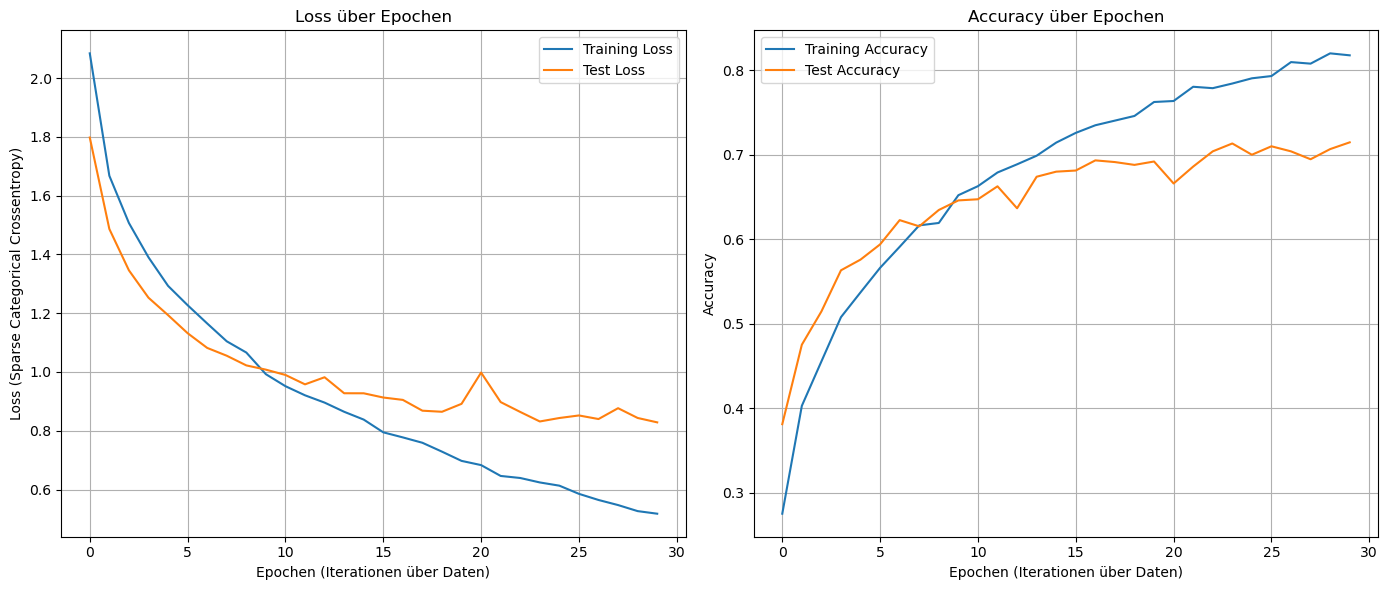

In [15]:
plot_history(history)

In [16]:
def load_mapping(dataset_path):
    with open(dataset_path, "r") as fp:
        data = json.load(fp)
    return data["mapping"]

In [17]:
def evaluate_model(
    model,
    X,
    y,
    class_names,
    model_name="Model",
    normalize=True,
    show_report=True
):
    """
    Evaluate a classification model with confusion matrices and optional report.

    Parameters
    ----------
    model : tf.keras.Model
        Trained Keras model.
    X : np.ndarray
        Input data (e.g. X_test).
    y : np.ndarray
        True labels.
    class_names : list[str]
        List of class/genre names in correct label order.
    model_name : str
        Name of the model (used in plot titles).
    normalize : bool
        Whether to show a normalized confusion matrix.
    show_report : bool
        Whether to print classification report.
    """

    # Predictions
    y_prob = model.predict(X, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    # ---------- Confusion Matrix (Counts)
    cm = confusion_matrix(y, y_pred)

    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=class_names
    )
    disp.plot(
        xticks_rotation=90,
        values_format="d",
        cmap=None
    )
    plt.title(f"{model_name} – Confusion Matrix (Counts)")
    plt.tight_layout()
    plt.show()

    # ---------- Confusion Matrix (Normalized per true class)
    if normalize:
        cm_norm = confusion_matrix(y, y_pred, normalize="true")

        plt.figure(figsize=(10, 8))
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm_norm,
            display_labels=class_names
        )
        disp.plot(
            xticks_rotation=90,
            values_format=".2f",
            cmap=None
        )
        plt.title(f"{model_name} – Confusion Matrix (Normalized)")
        plt.tight_layout()
        plt.show()

    # ---------- Classification report
    if show_report:
        print(f"\nClassification Report – {model_name}")
        print(
            classification_report(
                y,
                y_pred,
                target_names=class_names,
                digits=3
            )
        )

    return y_pred


<Figure size 1000x800 with 0 Axes>

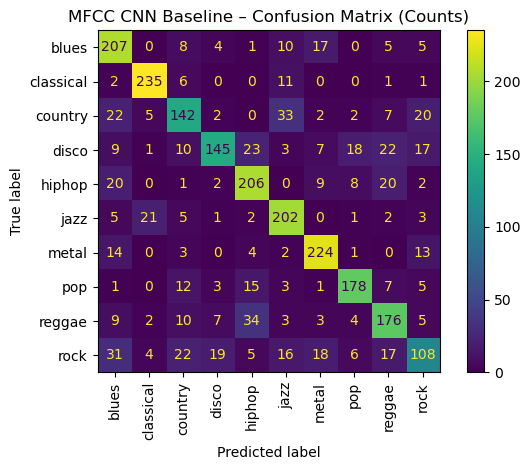

<Figure size 1000x800 with 0 Axes>

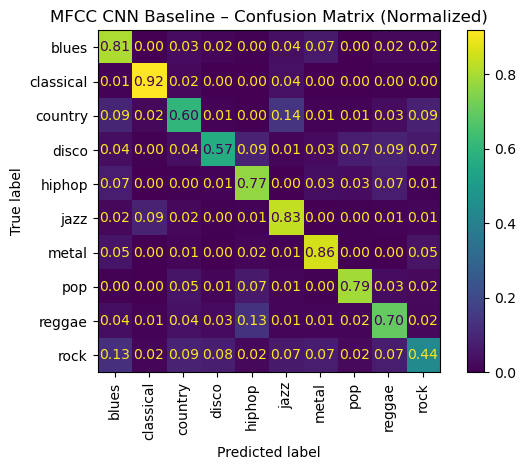


Classification Report – MFCC CNN Baseline
              precision    recall  f1-score   support

       blues      0.647     0.805     0.718       257
   classical      0.877     0.918     0.897       256
     country      0.648     0.604     0.626       235
       disco      0.792     0.569     0.662       255
      hiphop      0.710     0.769     0.738       268
        jazz      0.714     0.835     0.770       242
       metal      0.797     0.858     0.827       261
         pop      0.817     0.791     0.804       225
      reggae      0.685     0.696     0.690       253
        rock      0.603     0.439     0.508       246

    accuracy                          0.730      2498
   macro avg      0.729     0.728     0.724      2498
weighted avg      0.729     0.730     0.725      2498



array([4, 5, 6, ..., 9, 7, 4])

In [18]:
class_names = load_mapping(DATA_PATH)

evaluate_model(
    model=model,
    X=X_test,
    y=y_test,
    class_names=class_names,
    model_name="MFCC CNN Baseline"
)


In [19]:
# X_train hat (N,130,13,1) -> kanal entfernen
X_train_3d = X_train[..., 0]  # (N,130,13)
X_val_3d   = X_validation[..., 0]
X_test_3d  = X_test[..., 0]

In [20]:
print(X_train_3d.shape)
print(X_val_3d.shape)
print(X_test_3d.shape)

(5993, 130, 13)
(1499, 130, 13)
(2498, 130, 13)


In [21]:
def add_deltas(X):
    """
    Add delta and delta-delta features to MFCCs.

    Parameters
    ----------
    X : np.ndarray
        Shape (N, T, 13) – MFCC features without channel dimension.

    Returns
    -------
    np.ndarray
        Shape (N, T, 13, 3) – MFCC, delta, delta-delta stacked as channels.
    """
    X_out = []

    for x in X:
        # x: (T, 13)
        mfcc = x.T  # (13, T)

        delta = librosa.feature.delta(mfcc)
        delta2 = librosa.feature.delta(mfcc, order=2)

        # Stack channels -> (13, T, 3)
        stacked = np.stack([mfcc, delta, delta2], axis=-1)

        # Back to (T, 13, 3)
        X_out.append(stacked.transpose(1, 0, 2))

    return np.array(X_out, dtype=np.float32)


In [22]:
X_train_3d = add_deltas(X_train_3d)
X_val_3d = add_deltas(X_val_3d)
X_test_3d = add_deltas(X_test_3d)

print(X_train_3d.shape, X_val_3d.shape, X_test_3d.shape)  # (..,130,13,3)

(5993, 130, 13, 3) (1499, 130, 13, 3) (2498, 130, 13, 3)


In [24]:
input_shape_3d = (X_train_3d.shape[1], X_train_3d.shape[2], X_train_3d.shape[3]) 
model_3d = build_model(input_shape_3d)

#compile 3d Modell
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_3d.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_3d.summary()

history_3d = model_3d.fit(X_train_3d, y_train, validation_data=(X_val_3d, y_validation), batch_size=32, epochs=30, callbacks=[early])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 130, 13, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 65, 7, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 65, 7, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 65, 7, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 33, 4, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 33, 4, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 33, 4, 32)      │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 2, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 17, 2, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1088)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        69,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,002 (332.04 KB)

 Trainable params: 84,810 (331.29 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.2280 - loss: 2.3465 - val_accuracy: 0.3963 - val_loss: 1.7386
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4197 - loss: 1.6186 - val_accuracy: 0.4910 - val_loss: 1.4357
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4722 - loss: 1.4553 - val_accuracy: 0.5197 - val_loss: 1.3265
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5170 - loss: 1.3483 - val_accuracy: 0.5597 - val_loss: 1.2429
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5594 - loss: 1.2452 - val_accuracy: 0.5637 - val_loss: 1.2218
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5768 - loss: 1.2032 - val_accuracy: 0.5791 - val_loss: 1.1370
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5998 - loss: 1.1262 - val_accuracy: 0.6091 - val_loss: 1.0884
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6219 - loss: 1.0680 - val_accuracy: 

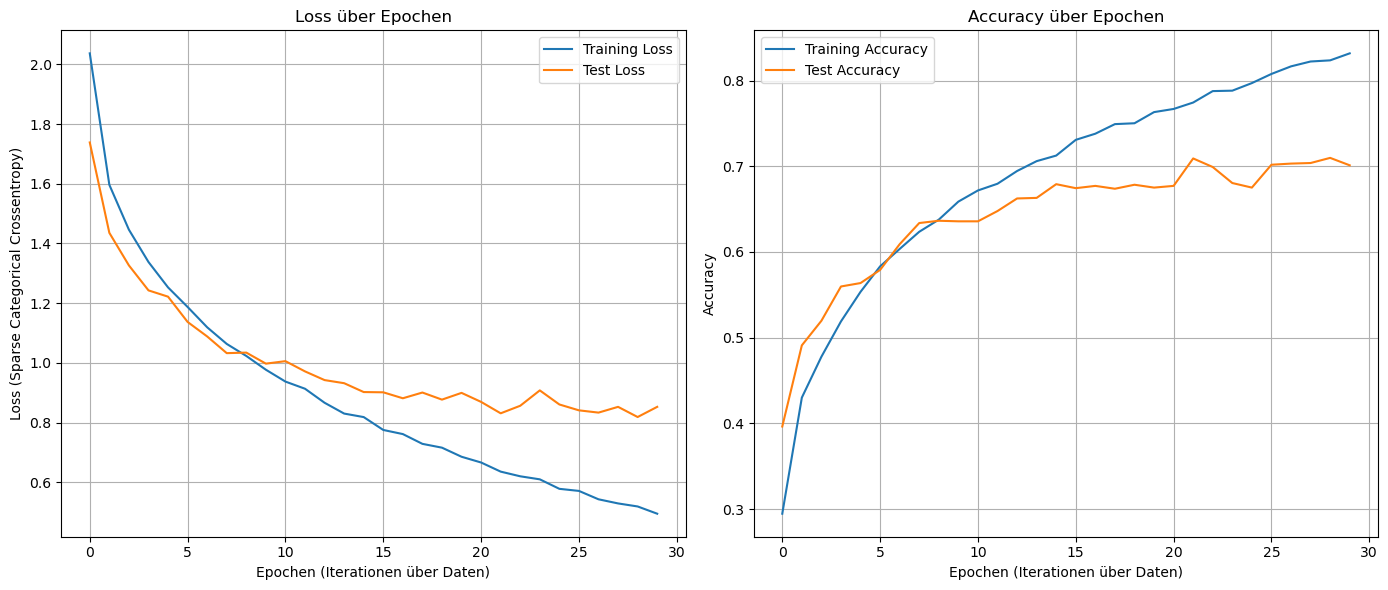

In [25]:
plot_history(history_3d)

In [27]:
test_loss_3d, test_accuracy_3d = model_3d.evaluate(X_test_3d, y_test, verbose=2)
print("Accuracy auf Testset ist: {}".format(test_accuracy_3d))

79/79 - 1s - 9ms/step - accuracy: 0.7254 - loss: 0.7837
Accuracy auf Testset ist: 0.7253803014755249


In [30]:
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")


Validation Loss: 0.8033
Validation Accuracy: 0.7298


In [31]:
val_loss, val_acc = model_3d.evaluate(X_test_3d, y_test, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

Validation Loss: 0.7837
Validation Accuracy: 0.7254


In [32]:
idx = 0  # oder irgendein Index
X_sample = X_test_3d[idx]   # shape: (130, 13, 3)
y_sample = y_test[idx]

print("Label:", y_sample)
print("Shape:", X_sample.shape)


Label: 4
Shape: (130, 13, 3)


In [33]:
mfcc   = X_sample[:, :, 0]
delta  = X_sample[:, :, 1]
delta2 = X_sample[:, :, 2]

print("MFCC min/max:", mfcc.min(), mfcc.max())
print("Delta min/max:", delta.min(), delta.max())
print("Delta² min/max:", delta2.min(), delta2.max())


MFCC min/max: -367.04358 190.11151
Delta min/max: -29.990711 29.061949
Delta² min/max: -19.92208 20.995316


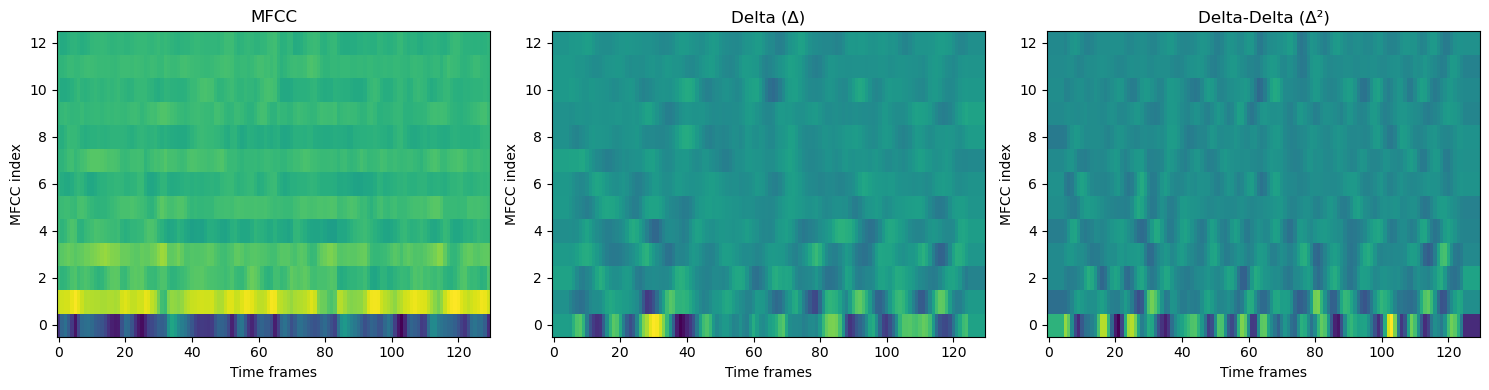

In [34]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].imshow(mfcc.T, aspect="auto", origin="lower")
axs[0].set_title("MFCC")

axs[1].imshow(delta.T, aspect="auto", origin="lower")
axs[1].set_title("Delta (Δ)")

axs[2].imshow(delta2.T, aspect="auto", origin="lower")
axs[2].set_title("Delta-Delta (Δ²)")

for ax in axs:
    ax.set_xlabel("Time frames")
    ax.set_ylabel("MFCC index")

plt.tight_layout()
plt.show()


In [37]:
conv1 = model_3d.layers[0]   # falls Input-Layer davor ist
W, b = conv1.get_weights()

print(W.shape)



(3, 3, 3, 32)


In [38]:
channel_energy = np.mean(np.abs(W), axis=(0,1,3))
print("MFCC:", channel_energy[0])
print("Delta:", channel_energy[1])
print("Delta-Delta:", channel_energy[2])


MFCC: 0.070772015
Delta: 0.07048661
Delta-Delta: 0.07058336


<Figure size 1000x800 with 0 Axes>

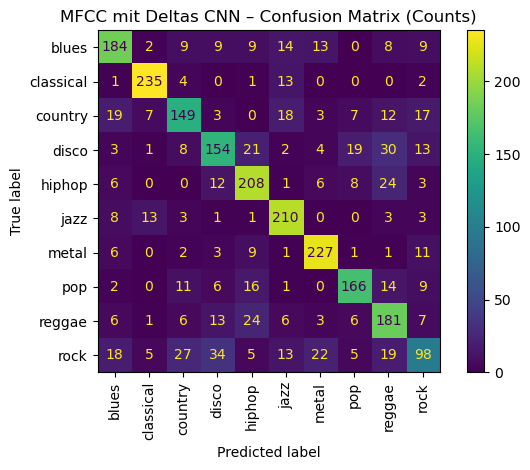

<Figure size 1000x800 with 0 Axes>

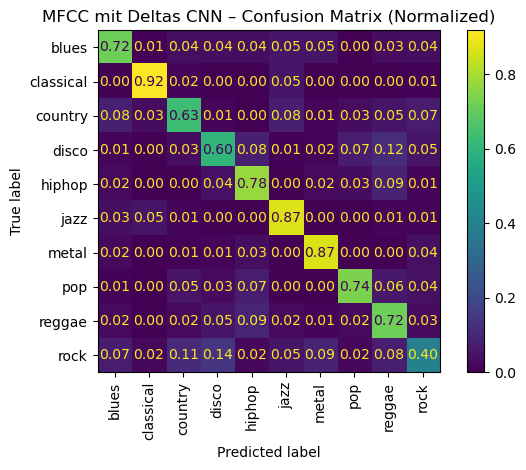


Classification Report – MFCC mit Deltas CNN
              precision    recall  f1-score   support

       blues      0.727     0.716     0.722       257
   classical      0.890     0.918     0.904       256
     country      0.680     0.634     0.656       235
       disco      0.655     0.604     0.629       255
      hiphop      0.707     0.776     0.740       268
        jazz      0.753     0.868     0.806       242
       metal      0.817     0.870     0.842       261
         pop      0.783     0.738     0.760       225
      reggae      0.620     0.715     0.664       253
        rock      0.570     0.398     0.469       246

    accuracy                          0.725      2498
   macro avg      0.720     0.724     0.719      2498
weighted avg      0.721     0.725     0.720      2498



array([4, 5, 9, ..., 7, 7, 4])

In [39]:
evaluate_model(
    model=model_3d,
    X=X_test_3d,
    y=y_test,
    class_names=class_names,
    model_name="MFCC mit Deltas CNN"
)